
# Objective:
To develop a robust exercise recommendation system based solely on static exercise data and similarity scores.


1. Feature Selection:

This section discusses the selection of relevant features from the dataset. Feature selection is crucial for model accuracy and performance, ensuring that only pertinent variables are used in the recommendation algorithm.

2. Feature Processing:

This phase involves preparing the selected features for the machine learning model. The process includes normalizing or scaling numerical data, encoding categorical variables, and handling missing values. Properly processed features are essential for accurate predictions and effective training of the model.

3. Development of Preprocessing Pipeline:

A comprehensive preprocessing pipeline is developed to handle the diverse types of data in the dataset, including textual, categorical, and numerical data. The pipeline ensures consistent and efficient transformation of data into a format suitable for model training. The section likely concludes with testing the pipeline using sample user inputs.

4. Exercise Recommendation Testing:

The notebook concludes with testing the recommendation system using sample user inputs. This step is crucial for validating the effectiveness of the model and the preprocessing steps.


### Feature Selection


The rating helps the model learn to associate user preferences with the perceived effectiveness of exercises, leading to more personalized and tailored suggestions.

In [1]:
import pandas as pd
import numpy as np

# Import data generated upstream
exercises_data_full = pd.read_csv("../data/exercises_difficulty_classification_full.csv")
merged_data = pd.read_csv("../data/merged_exercise_user_data.csv")

In [2]:
non_features = ['Level', 'Difficulty', 'index', 'Name']

df_features = exercises_data_full.loc[:,[feature not in non_features for feature in exercises_data_full.columns]]
df_features.head()

,Muscle,Equipment,Rating,Type,Description,Summary,Reasoning,Overall_Difficulty,Optimality
0,Forearms,Other,9.6,Strongman,"1. Position the frame at the starting point, a...",Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ...",Beginner,Excellent
1,Quadriceps,Machine,9.6,Strength,1. Load the sled to an appropriate weight. Sea...,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo...",Beginner,Excellent
2,Abdominals,Other,9.5,Strength,1. Position a bar into a landmine or securely ...,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...,Intermediate,Excellent
3,Lats,Other,9.5,Strength,1. Attach a weight to a dip belt and secure it...,Pull-ups performed with additional weight.,"High intensity and strength demand, suitable f...",Advanced,Excellent
4,Middle Back,Other,9.5,Strength,1. Position a bar into a landmine or in a corn...,Rowing movement with a barbell fixed at one end.,Requires substantial technical skill and moder...,Intermediate,Excellent



### Process Features


In [3]:
# from sklearn.model_selection import train_test_split

# seed = 42
# np.random.seed(seed)

# Split the dataset into training, validation, and test sets
# train_data, temp_data = train_test_split(df_features, test_size = 0.3, random_state = seed)
# test_data, val_data = train_test_split(temp_data, test_size = 0.5, random_state = seed)

# train_data.reset_index(drop = True, inplace = True)
# val_data.reset_index(drop = True, inplace = True)
# test_data.reset_index(drop = True, inplace = True)

# Y_train, Y_val, Y_test = train_data.pop('Name'), val_data.pop('Name'), test_data.pop('Name')

In [4]:
train_data = df_features.copy(deep = True)
print(f"Training: {train_data.shape}")
# print(f"Validation: {val_data.shape}")
# print(f"Test: {test_data.shape}")

Training: (1083, 9)


In [5]:
train_data.head()

,Muscle,Equipment,Rating,Type,Description,Summary,Reasoning,Overall_Difficulty,Optimality
0,Forearms,Other,9.6,Strongman,"1. Position the frame at the starting point, a...",Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ...",Beginner,Excellent
1,Quadriceps,Machine,9.6,Strength,1. Load the sled to an appropriate weight. Sea...,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo...",Beginner,Excellent
2,Abdominals,Other,9.5,Strength,1. Position a bar into a landmine or securely ...,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...,Intermediate,Excellent
3,Lats,Other,9.5,Strength,1. Attach a weight to a dip belt and secure it...,Pull-ups performed with additional weight.,"High intensity and strength demand, suitable f...",Advanced,Excellent
4,Middle Back,Other,9.5,Strength,1. Position a bar into a landmine or in a corn...,Rowing movement with a barbell fixed at one end.,Requires substantial technical skill and moder...,Intermediate,Excellent


Develop preprocessing pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import text
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK resources (run this once if you haven't downloaded them before)
# nltk.download('punkt')
# nltk.download('wordnet')

def get_stop_words():
    # Get the default English stop words list from scikit-learn
    stop_words = text.ENGLISH_STOP_WORDS

    # Extend the stop words list with number-like tokens
    numbers = map(str, range(101))
    additional_words =['00','150','175','450','exercise','begin','start','use','second','try','repeat','allow','angle','degrees','weight','then',
                       'hold','after','once','again','reps','position','contract','return','inch','face','front','away','toward',]
    extended_stop_words = list(stop_words) + list(numbers)

    return extended_stop_words

def lemmatize_text(text):
    stop_words = get_stop_words()
    
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words] # prevent tokenizing stop words
    return ' '.join(lemmatized_words)

# Custom scaler to give weight to more important features
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns, scale_factor = 2.0):
        self.columns = columns
        self.scale_factor = scale_factor

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[:, self.columns] *= self.scale_factor
        return X_new
        
def get_feature_pipeline(components = None):
    extended_stop_words = get_stop_words()
    
    # Text representation using TF-IDF, standardization, and one-hot encoding
    column_representation = ColumnTransformer(
        transformers=[
            # ('text_name_exercise', TfidfVectorizer(max_features = 2000, max_df = 0.8, min_df = 2,
            #                                               preprocessor = lemmatize_text,
            #                                               stop_words = extended_stop_words),
            #  'Name'),
            ('text_description_exercise', TfidfVectorizer(max_features = 2000, max_df = 0.4, min_df = 3,
                                                          preprocessor = lemmatize_text,
                                                          stop_words = extended_stop_words),
             'Description'),
            ('text_summary_exercise', TfidfVectorizer(max_features = 2000, max_df = 0.7, min_df = 2,
                                                      preprocessor = lemmatize_text,
                                                      stop_words = extended_stop_words),
             'Summary'),
            ('text_reasoning_exercise', TfidfVectorizer(max_features = 2000, max_df = 0.7, min_df = 2,
                                                        preprocessor = lemmatize_text,
                                                        stop_words = extended_stop_words),
             'Reasoning'),
            ('scaler', MinMaxScaler(), ['Rating']), # perform min-max scaling for clustering methods and to match [0,1] range of one hot encoded features
#            ('ordinal_user', OrdinalEncoder(categories = [['Beginner', 'Intermediate', 'Advanced']]), ['Fitness_Experience']),
            ('ordinal_exercise', OrdinalEncoder(categories = [['Beginner', 'Intermediate', 'Advanced']]), ['Overall_Difficulty']),
#            ('one_hot_user', OneHotEncoder(sparse_output = False), ['Workout_Type', 'Desired_Muscle_Groups', 'Available_Equipment']),
            ('one_hot_exercise', OneHotEncoder(sparse_output = False), ['Type', 'Muscle', 'Equipment', 'Optimality'])
        ],
        remainder = 'passthrough'
    )

#    muscle_equipment_columns = range(2076, 2083) # [2076, 2083), [2083, 2100) for 'Muscle', [2100, 2117) for 'Equipment'
#    custom_scaler = CustomScaler(columns = muscle_equipment_columns, scale_factor = 2.0)
    
    if components: # If optimal # of components is determined
        # Define TruncatedSVD
        svd = TruncatedSVD(n_components = components, random_state = 42)
        
        # Create a pipeline with TF-IDF, TruncatedSVD, and the rest of transformers in column_representation
        pipeline = Pipeline([
            ('tfidf', column_representation),
 #           ('custom_scaler', custom_scaler),
            ('svd', svd)
        ])
    else:
        # Create a pipeline with TF-IDF, TruncatedSVD, and the rest of transformers in column_representation
        pipeline = Pipeline([
            ('tfidf', column_representation),
#            ('custom_scaler', custom_scaler),
        ])
    return pipeline

In [7]:
feature_pipeline = get_feature_pipeline()
X_train_transformed = feature_pipeline.fit_transform(train_data)
X_train_transformed

<1083x2121 sparse matrix of type '<class 'numpy.float64'>'
	with 59228 stored elements in Compressed Sparse Row format>


The parameters for TfidfVectorizer were determined by viewing the produced features.


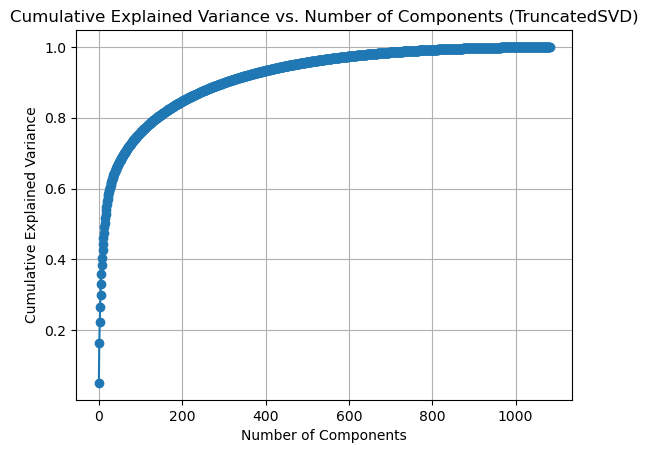

In [8]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# TruncatedSVD
svd = TruncatedSVD(n_components = X_train_transformed.shape[1], random_state = 42)
svd.fit(X_train_transformed)

# Plot cumulative explained variance
explained_variance_ratio_cumulative = svd.explained_variance_ratio_.cumsum()
plt.plot(explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components (TruncatedSVD)')
plt.grid(True)
plt.show()

In [9]:
from kneed import KneeLocator
x = np.arange(0, len(explained_variance_ratio_cumulative))
y = explained_variance_ratio_cumulative
kn = KneeLocator(x, y, curve = 'concave', direction = 'increasing')
print(f"# Components: {kn.knee}")
print(f"Cumulative Explained Variance: {y[kn.knee]}")

# Components: 145
Cumulative Explained Variance: 0.8055529856617137


In [10]:
full_feature_pipeline = get_feature_pipeline(kn.knee)
X_train = full_feature_pipeline.fit_transform(train_data)
# X_val = full_feature_pipeline.transform(val_data)
# X_test = full_feature_pipeline.transform(test_data)

In [11]:
# Save transformed features

# np.save("../data/transformed/X_train", X_train)

X_train = np.load("../data/transformed/X_train.npy")

assert len(X_train) == len(train_data)

In [12]:
import pickle

# pickle.dump(full_feature_pipeline, open('model/full_feature_pipeline.pkl','wb'))
model = pickle.load(open('../model/full_feature_pipeline.pkl','rb'))


## Model Validation


In [13]:
from scipy.sparse import csr_matrix
sparse_X_train_csr = csr_matrix(X_train)

Calculate cosine similarity and recommend top similar items

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Convert numpy matrices to CSR format
sparse_X_train_csr = csr_matrix(X_train)

# Calculate cosine similarity for sparse data
cosine_similarity_train = cosine_similarity(sparse_X_train_csr, sparse_X_train_csr)

# Recommend top k similar items for a given item
def recommend_similar_items(item_index, item_name, threshold = 0.0):
    # Use cosine similarity for recommendations
    similarities = cosine_similarity_train[item_index]

    # Get indices and scores of items with similarity >= threshold
    similar_indices_and_scores = [(idx, score) for idx, score in enumerate(similarities) if score >= threshold]

    # Convert to DataFrame
    result_df = pd.DataFrame(similar_indices_and_scores, columns = ['index', 'Cosine_Similarity_Score'])
    result_df['Compared_Exercise'] = item_name 

    return result_df.sort_values('Cosine_Similarity_Score', ascending = False).reset_index(drop = True).head(3)

In [15]:
target_item_index = 18
target_item_name = 'Barbell Deadlift'
recommend_similar_items(target_item_index, target_item_name)

,index,Cosine_Similarity_Score,Compared_Exercise
0,18,1.000000,Barbell Deadlift
1,266,0.822755,Barbell Deadlift
2,483,0.818254,Barbell Deadlift


In [16]:
exercises_data_full.loc[[18,266,483],:]

,index,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning,Overall_Difficulty,Optimality
18,18,Barbell Deadlift,Hamstrings,Barbell,9.4,Strength,Intermediate,1. Approach the bar so that it is centered ove...,Intermediate,Lifting a barbell off the ground to hip level.,Moderate complexity and technical skill required.,Intermediate,Excellent
266,266,Power clean,Hamstrings,Barbell,8.7,Strength,Intermediate,Note:\n This exercise is extremely complex and...,Advanced,Olympic weightlifting movement involving a clean.,"Requires power, speed, and technique.",Advanced,Excellent
483,483,Romanian Deadlift,Hamstrings,Barbell,8.1,Strength,Intermediate,1. Hold a bar at hip level with a pronated (pa...,Intermediate,Deadlift exercise focusing on the hamstrings u...,"Focuses on hamstrings, requires good form and ...",Intermediate,Excellent



## Model Validation


Examine the accuracy and efficacy of the recommendation through an example.

In [17]:
# Example usage
level = 'Intermediate'
muscle = 'Shoulders'
exercise_type = 'Strength'
equipment = 'Gym (Equipment)'

In [18]:
# Get exercises matching user inputs
def get_exercises_from_user_inputs(experience, muscle, type, equipment):
    has_experience = merged_data.Fitness_Experience == experience
    has_muscle = merged_data.Desired_Muscle_Groups == muscle
    has_type = merged_data.Workout_Type == type
    has_equipment = merged_data.Available_Equipment == equipment
    
    filtered_df = merged_data[has_experience & has_muscle & has_type & has_equipment]
    filtered_df = filtered_df.drop(['User_ID', 'Workout_Frequency'], axis=1).drop_duplicates()

    # Creating a new dataframe with the specified columns
    df_selected_columns = filtered_df[['index', 'Name', 'Rating']]

    return df_selected_columns

# Get data of recommended exercises from user inputs
def get_exercise_recommendation(experience, muscle, type, equipment):
    exercise_queries = get_exercises_from_user_inputs(experience, muscle, type, equipment)

    ret_list = []
    for row in exercise_queries.iterrows():
        df_recommend = recommend_similar_items(row[1]['index'], row[1].Name)
        df_recommend_full = pd.merge(df_recommend, exercises_data_full, on = 'index')
        ret_list.append(df_recommend_full)

    return pd.concat(ret_list, ignore_index = True).rename({'Name': 'Recommended_Exercise'}, axis = 1)

In [19]:
sample_recommend = get_exercise_recommendation(level, muscle, exercise_type, equipment)
sample_recommend.drop('Description', axis = 1)

,index,Cosine_Similarity_Score,Compared_Exercise,Recommended_Exercise,Muscle,Equipment,Rating,Type,Level,Difficulty,Summary,Reasoning,Overall_Difficulty,Optimality
0,30,1.000000,Military press,Military press,Shoulders,Barbell,9.3,Strength,Intermediate,Intermediate,Overhead barbell press from a standing position.,Moderate technical skill and shoulder strength...,Intermediate,Excellent
1,49,0.929824,Military press,Seated barbell shoulder press,Shoulders,Barbell,9.2,Strength,Intermediate,Intermediate,Overhead press with a barbell while seated.,"Moderate complexity, requires shoulder strengt...",Intermediate,Excellent
2,265,0.892991,Military press,Barbell Shoulder Press,Shoulders,Barbell,8.7,Strength,Intermediate,Intermediate,Shoulder press performed with a barbell.,"Fundamental shoulder exercise, requires streng...",Intermediate,Excellent
3,49,1.000000,Seated barbell shoulder press,Seated barbell shoulder press,Shoulders,Barbell,9.2,Strength,Intermediate,Intermediate,Overhead press with a barbell while seated.,"Moderate complexity, requires shoulder strengt...",Intermediate,Excellent
4,30,0.929824,Seated barbell shoulder press,Military press,Shoulders,Barbell,9.3,Strength,Intermediate,Intermediate,Overhead barbell press from a standing position.,Moderate technical skill and shoulder strength...,Intermediate,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,460,0.890939,Incline face-down bar front raise,Incline anti-gravity shoulder press,Shoulders,E-Z Curl Bar,8.2,Strength,Intermediate,Intermediate,Shoulder press performed on an incline bench a...,"Targets the shoulders, incline angle challenge...",Intermediate,Excellent
119,335,0.792729,Incline face-down bar front raise,Single-arm incline lateral raise,Shoulders,Dumbbell,8.5,Strength,Intermediate,Intermediate,"Lateral raise performed on an incline bench, o...","Targets the shoulder muscles, incline increase...",Intermediate,Excellent
120,460,1.000000,Incline anti-gravity shoulder press,Incline anti-gravity shoulder press,Shoulders,E-Z Curl Bar,8.2,Strength,Intermediate,Intermediate,Shoulder press performed on an incline bench a...,"Targets the shoulders, incline angle challenge...",Intermediate,Excellent
121,407,0.890939,Incline anti-gravity shoulder press,Incline face-down bar front raise,Shoulders,E-Z Curl Bar,8.3,Strength,Intermediate,Intermediate,Front raise exercise for the shoulders perform...,"Targets the front deltoids, incline position i...",Intermediate,Excellent


In [20]:
# Examine recommendations using table lookup
sample_lookup = get_exercises_from_user_inputs(level, muscle, exercise_type, equipment)
sample_lookup.head()

,index,Name,Rating
271275,30,Military press,9.3
271276,49,Seated barbell shoulder press,9.2
271277,256,Standing Bradford press,8.7
271278,265,Barbell Shoulder Press,8.7
271279,337,Barbell rear delt bent-over row,8.5


In [21]:
def get_unique_recommendations(level, muscle, exercise_type, equipment):
    # Assuming you have functions get_exercise_recommendation and get_exercises_from_user_inputs

    # Get dataframes based on input parameters
    df_recommendation = get_exercise_recommendation(level, muscle, exercise_type, equipment)
    df_user_inputs = get_exercises_from_user_inputs(level, muscle, exercise_type, equipment).drop(['Name','Rating'], axis = 1)

    # Merge dataframes based on 'index'
    merged_df = pd.merge(df_recommendation, df_user_inputs, on = 'index', how = 'left', indicator = True)

    # Keep only the rows present in the recommendation dataframe exclusively
    result_df = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis = 1)

    # If needed, reset the index
    result_df.reset_index(drop = True, inplace = True)

    return result_df

result_dataframe = get_unique_recommendations(level, muscle, exercise_type, equipment)
result_dataframe.drop(['index','Rating','Level','Description','Summary','Reasoning','Level','Optimality', 'Difficulty'], axis = 1)

,Cosine_Similarity_Score,Compared_Exercise,Recommended_Exercise,Muscle,Equipment,Type,Overall_Difficulty
0,0.725165,Machine Shoulder (Military) Press,Clam,Abductors,Mat,Strength,Beginner
1,0.677840,Machine Shoulder (Military) Press,Glute bridge,Glutes,Body Only,Strength,Beginner
2,0.768394,Barbell front raise,Kettlebell Seated Press,Shoulders,Kettlebells,Strength,Beginner
3,0.758865,Barbell front raise,One-Arm Flat Bench Dumbbell Flye,Chest,Dumbbell,Strength,Beginner
4,0.807952,Overhead bar front raise,Kipping Muscle Up,Lats,Body Only,Strength,Advanced
5,0.747916,Overhead bar front raise,Feet-elevated crunch,Abdominals,Exercise Ball,Strength,Intermediate
6,0.822058,Cuban press,Dumbbell front raise,Shoulders,Dumbbell,Strength,Beginner
7,0.750897,Single-arm side lying rear fly,Cable straight-bar upright row,Traps,Cable,Strength,Intermediate
8,0.902814,Single-arm dumbbell upright row,Feet-elevated crunch,Abdominals,Exercise Ball,Strength,Intermediate
9,0.855126,Single-arm kettlebell push-press,Single-arm kettlebell clean and jerk,Shoulders,Kettlebells,Strength,Advanced
